<h3>Import data and select relevant columns</h3>

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

df.head()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
0,0,1,5,6,5,3,6,4,5,4,...,3,3,3,1,1,2,2,1,1,2
1,1,1,5,3,5,5,6,4,5,5,...,0,0,0,0,0,0,2,0,0,0
2,1,1,5,5,6,5,5,6,4,5,...,3,2,3,2,2,1,3,2,2,2
3,1,1,6,6,6,6,5,6,6,6,...,2,1,1,0,0,1,1,1,1,3
4,0,1,4,6,6,6,3,6,4,5,...,3,3,2,2,2,3,1,0,0,1


<h3>Data pre-processing</h3>

<h5>Synthetic Minority Over-sampling Technique (SMOTE)</h5>
<p>SMOTE works by creating new synthetic examples of the minority class by combining the attributes of existing minority class instances. It does this by selecting a minority class instance and finding its nearest neighbors. Then, it randomly selects one or more of these neighbors and creates new synthetic instances by randomly selecting features from the selected neighbors and the original instance. This process helps to expand the minority class and balance the dataset.</p>


<h5>Adaptive Synthetic Sampling (ADASYN)</h5>
<p>ADASYN is an extension of the SMOTE algorithm designed to address some of its limitations, particularly in scenarios where the distribution of the minority class is highly skewed or complex. ADASYN dynamically adjusts the importance of different minority class instances when generating synthetic samples, focusing more on samples that are harder to classify. It identifies the difficulty of classifying each minority class instance by measuring the density distribution around it. Instances that are harder to classify because they lie in low-density regions are given higher importance. Synthetic samples are then generated for each minority class instance, with the number of synthetic samples generated for each instance being proportional to its difficulty level. This adaptive nature makes ADASYN particularly useful in scenarios where the class imbalance is severe or where the minority class distribution is complex and non-linear.</p>

In [191]:
from imblearn.over_sampling import SMOTE, ADASYN
# gender split of the dataset
print(f"Gender split before balancing the dataset: {len(df[df['gender'] == 0])} women to {len(df[df['gender'] == 1])} men.")

Gender split before balancing the dataset: 177 women to 43 men.


In [192]:
# balance the dataset in regards to gender while keeping the same statistical properties
# Instantiate SMOTE
smote = SMOTE(k_neighbors=8, random_state=42)
adasyn = ADASYN(random_state=42)

X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0

<h5>Check whether SMOTE or ADASYN is better suited for balancing the dataset</h5>

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# oversample the training set using SMOTE
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# oversample the training set using ADASYN
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# train classifiers on balanced training sets
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_resampled_smote, y_resampled_smote)

rf_adasyn = RandomForestClassifier(random_state=42)
rf_adasyn.fit(X_resampled_adasyn, y_resampled_adasyn)

rf_og = RandomForestClassifier(random_state=42)
rf_og.fit(X_train, y_train)

# Evaluate classifiers on the original imbalanced test set
y_pred_smote = rf_smote.predict(X_test)
y_pred_adasyn = rf_adasyn.predict(X_test)
y_pred_og = rf_og.predict(X_test)

# Print classification reports to compare performance
print("Classification report for SMOTE-balanced classifier:")
print(classification_report(y_test, y_pred_smote))

print("\nClassification report for ADASYN-balanced classifier:")
print(classification_report(y_test, y_pred_adasyn))

print("\nClassification report for original classifier:")
print(classification_report(y_test, y_pred_og))

Classification report for SMOTE-balanced classifier:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        56
           1       0.30      0.30      0.30        10

    accuracy                           0.79        66
   macro avg       0.59      0.59      0.59        66
weighted avg       0.79      0.79      0.79        66


Classification report for ADASYN-balanced classifier:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        56
           1       0.43      0.30      0.35        10

    accuracy                           0.83        66
   macro avg       0.65      0.61      0.63        66
weighted avg       0.81      0.83      0.82        66


Classification report for original classifier:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        56
           1       0.00      0.00      0.00        10

    accuracy              

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN-balanced classifier seems to outperform the SMOTE-balanced one. Therefore from now one we will use the ADASYN-balanced dataset.

<h5>Apply ADASYN to balance the dataset</h5>

In [194]:
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
# gender split of the dataset
print(f"Gender split after balancing the dataset: {len(balanced_df[balanced_df['gender'] == 0])} women to {len(balanced_df[balanced_df['gender'] == 1])} men.")
balanced_df.describe()

Gender split after balancing the dataset: 177 women to 179 men.


,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.483146,3.553371,3.730337,4.797753,4.446629,3.904494,3.750000,3.334270,4.280899,...,1.561798,1.435393,1.311798,1.019663,0.772472,1.429775,1.629213,1.095506,1.039326,1.205056
std,0.500696,0.500419,1.585130,1.523628,1.421602,1.404205,1.529754,1.670582,1.696078,1.618476,...,1.006515,0.877760,0.952965,0.971223,0.826617,1.017099,0.962766,1.049148,1.047397,1.090330
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,3.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [195]:
# check if dataset was properly oversampled
#for col in balanced_df.columns:
#    print(set(balanced_df[col]))
balanced_df.head()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
0,0,1,5,6,5,3,6,4,5,4,...,3,3,3,1,1,2,2,1,1,2
1,1,1,5,3,5,5,6,4,5,5,...,0,0,0,0,0,0,2,0,0,0
2,1,1,5,5,6,5,5,6,4,5,...,3,2,3,2,2,1,3,2,2,2
3,1,1,6,6,6,6,5,6,6,6,...,2,1,1,0,0,1,1,1,1,3
4,0,1,4,6,6,6,3,6,4,5,...,3,3,2,2,2,3,1,0,0,1


<h3>Check for multicollinearity</h3>
<p>
Multicollinearity refers to a situation where two or more features are highly correlated. They provide the same or similar information about the target variable. This can cause problems when determining feature importance, as it can be hard to disentangle the effects of correlated features.

To avoid this, we can calculate the variance inflation factor (VIF) for each feature. A high VIF indicates that a feature is highly correlated with other features. If we find multicollinearity in the data we can remove one of the correlated features or merge two features into one.
</p>

In [196]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = balanced_df.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y = balanced_df['group'].copy() # adhd = 1 / no adhd = -1

def calculate_vif(X):
    # X - dataframe with independent features
    X_constant = add_constant(X)
    # calculate vif
    vif_vals = pd.DataFrame()
    vif_vals['var'] = X_constant.columns
    vif_vals['vif'] = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
    
    return vif_vals[vif_vals['var'] != 'const'].sort_values(by='vif', ascending=False)

vif_results = calculate_vif(X)
# iterate until all VIF values are less than 5
while vif_results['vif'].max() > 15: # CHANGE HERE
    # find the column with the highest VIF
    max_vif_column = vif_results.loc[vif_results['vif'].idxmax(), 'var']
    print(f'dropping {max_vif_column}')
    # Remove the column with the highest VIF
    X = X.drop(columns=[max_vif_column])
    # Recalculate VIF
    vif_results = calculate_vif(X)

vif_results.sort_values(by='vif', ascending=True)

,var,vif
18,tr18,2.258470
5,tr5,2.554202
11,tr11,2.594438
32,tr32,2.615505
39,tr39,2.834309
20,tr20,2.845857
40,tr40,3.280511
13,tr13,3.290511
35,tr35,3.344958
4,tr4,3.453130


In [197]:
cols_after_vif = vif_results['var'].tolist() + ['gender']
# selecting columns based on vif results - the remaining columns should be less correlated to each other 
X = balanced_df[cols_after_vif]
y = balanced_df['group']

<h3>Train, Test split of the balanced dataset</h3>
<p>
We split the dataset into train, test and validation sets, before scaling it to prevent data leakage. 
</p>

In [198]:
# split the balanced dataset 
X_balanced = X.copy()
y_balanced = y.copy() # adhd = 1 / no adhd = 0

In [199]:
# drop the gender column for training
X_balanced.drop(columns=['gender'], inplace=True)

In [200]:
# stratified splitting to preserve a balanced class split according to diagnosis
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, stratify=y, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42) 

In [201]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

# train your model using X_train_scaled and evaluate it using X_val_scaled
# after selecting the best model, you can evaluate its final performance on X_test_scaled

(240, 43)
(80, 43)
(36, 43)


<h3>Feature importance</h3>

<h5>Feature importance for the balanced dataset - mixed gender</h5>
<p>
Recursive Feature Elimination (RFE) is a feature selection technique that works by recursively removing features from the dataset and evaluating the performance of the model trained on the reduced feature set. It ranks the features based on their importance and eliminates the least important ones until the desired number of features is reached. </p>

In [202]:
num_features = 20
model = LogisticRegression(max_iter=500, random_state=42)

rfe = RFE(model, n_features_to_select=num_features)
rfe.fit(X_train_scaled, y_train)

rfe_selected_features = X_train.columns[rfe.support_]
rfe_selected_features

Index(['tr34', 'tr12', 'tr23', 'tr33', 'tr15', 'tr24', 'tr8', 'tr28', 'tr6',
       'tr9', 'tr21', 'tr19', 'tr14', 'tr4', 'tr35', 'tr13', 'tr40', 'tr20',
       'tr11', 'tr18'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix')

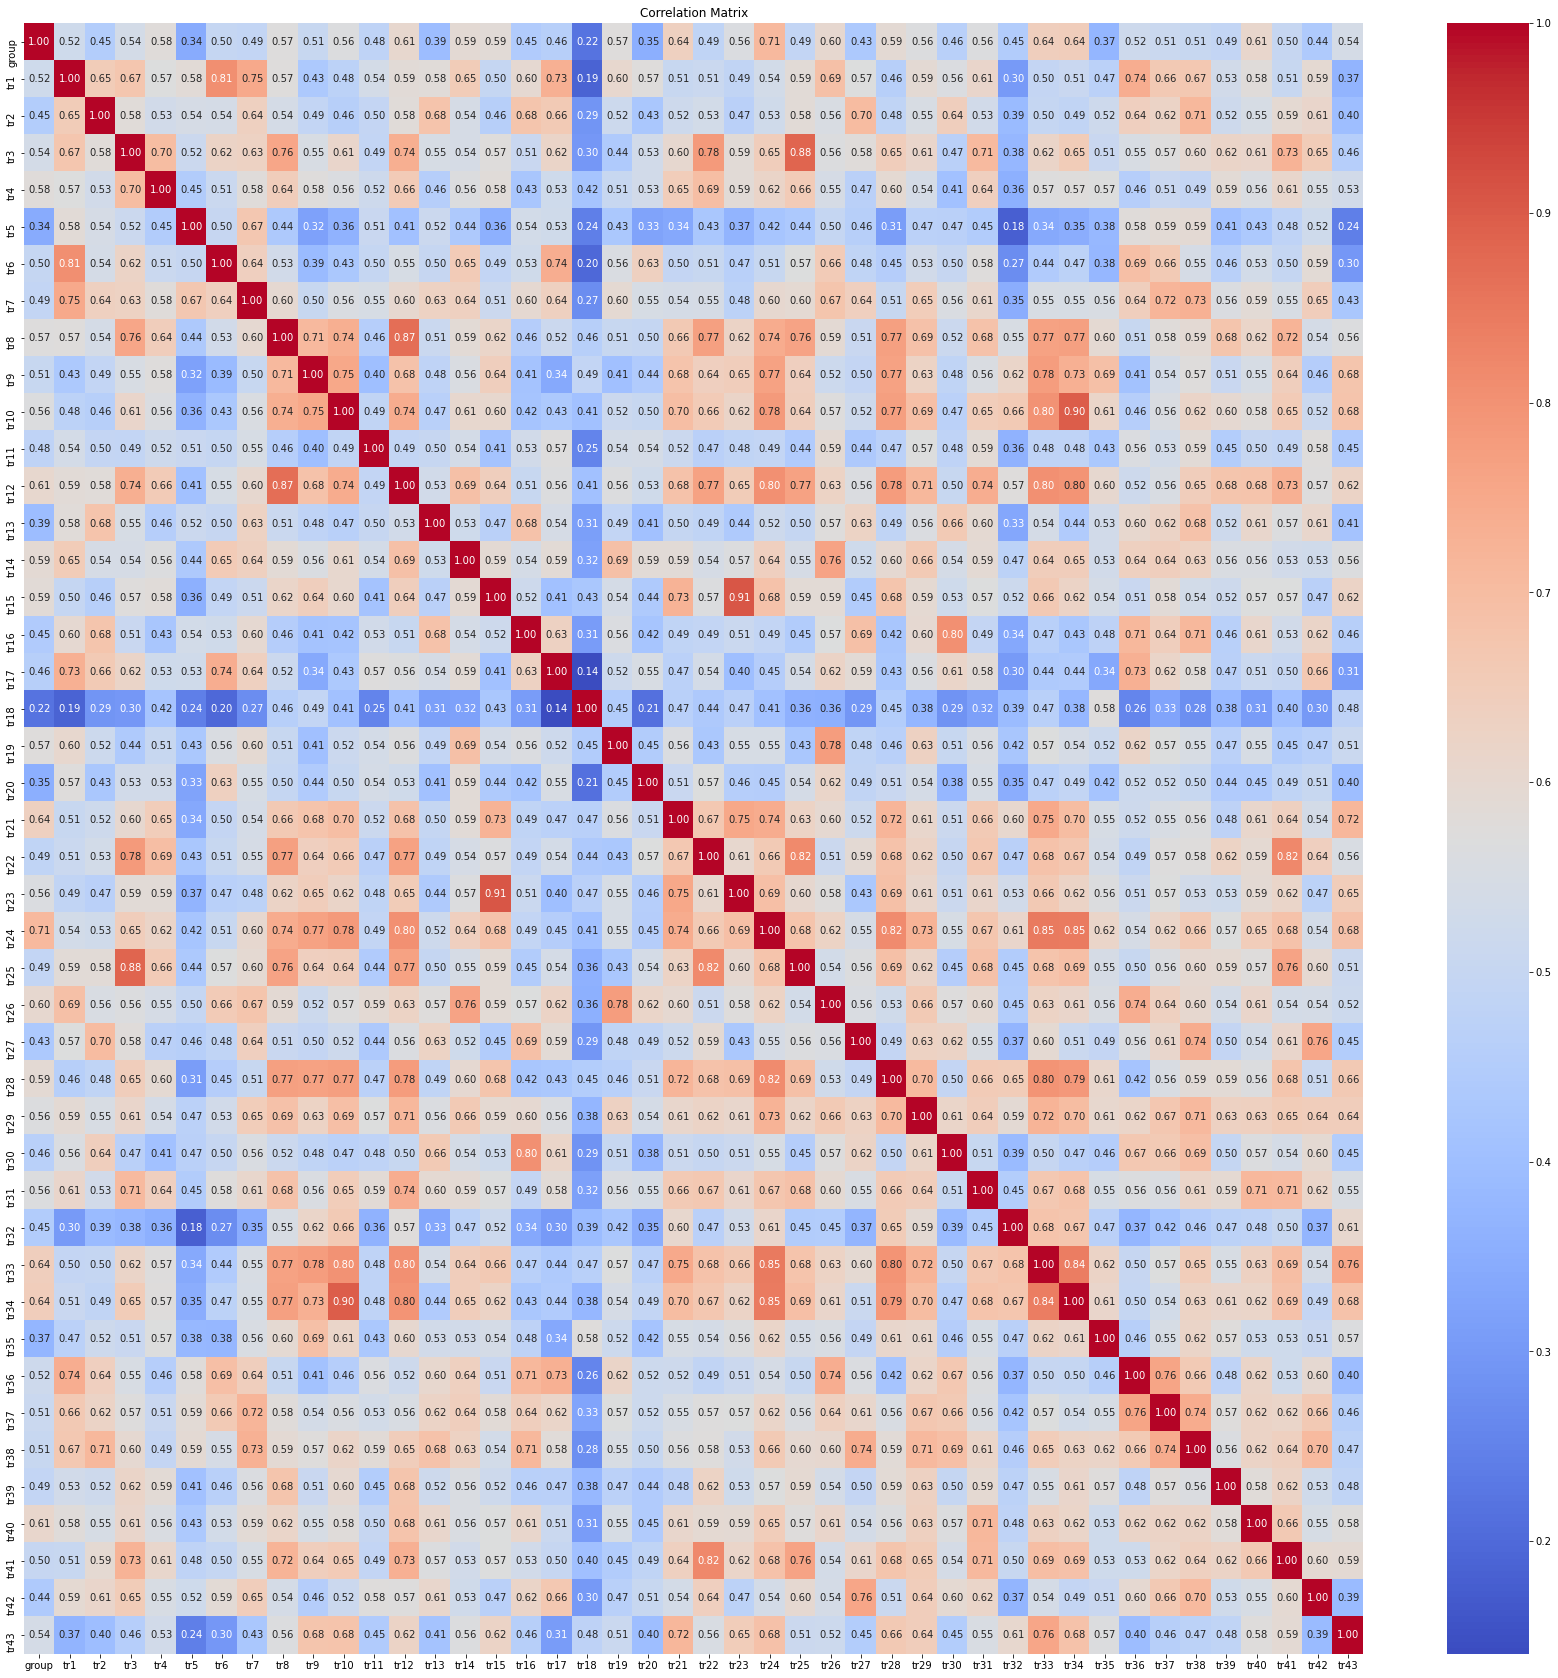

In [203]:
corr = balanced_df.filter(regex='tr|group').corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

['tr34', 'tr12', 'tr23', 'tr33', 'tr15', 'tr24', 'tr8', 'tr28', 'tr6', 'tr9', 'tr21', 'tr19', 'tr14', 'tr4', 'tr35', 'tr13', 'tr40', 'tr20', 'tr11', 'tr18', 'group']


Text(0.5, 1.0, 'Correlation Matrix for features selected using RFE')

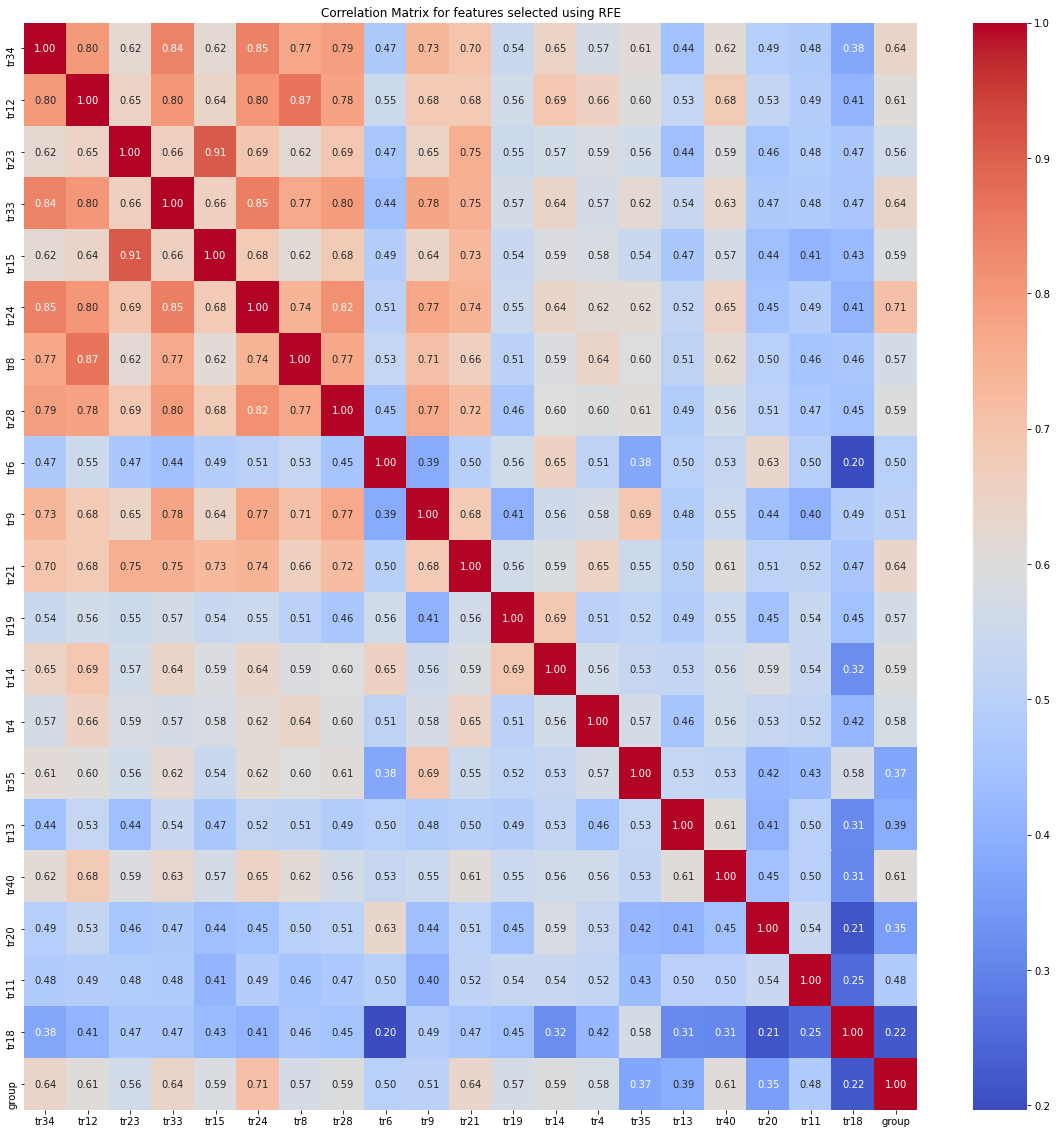

In [204]:
cols = rfe_selected_features.tolist() + ['group']
print(cols)
corr = balanced_df[cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix for features selected using RFE')

['tr34', 'tr12', 'tr23', 'tr33', 'tr15', 'tr24', 'tr10', 'tr8', 'tr26', 'tr36', 'tr28', 'tr21', 'tr29', 'tr31', 'tr19', 'tr43', 'tr14', 'tr4', 'tr40', 'tr11', 'group']


Text(0.5, 1.0, 'Correlation Matrix for features selected using ANOVA F-value')

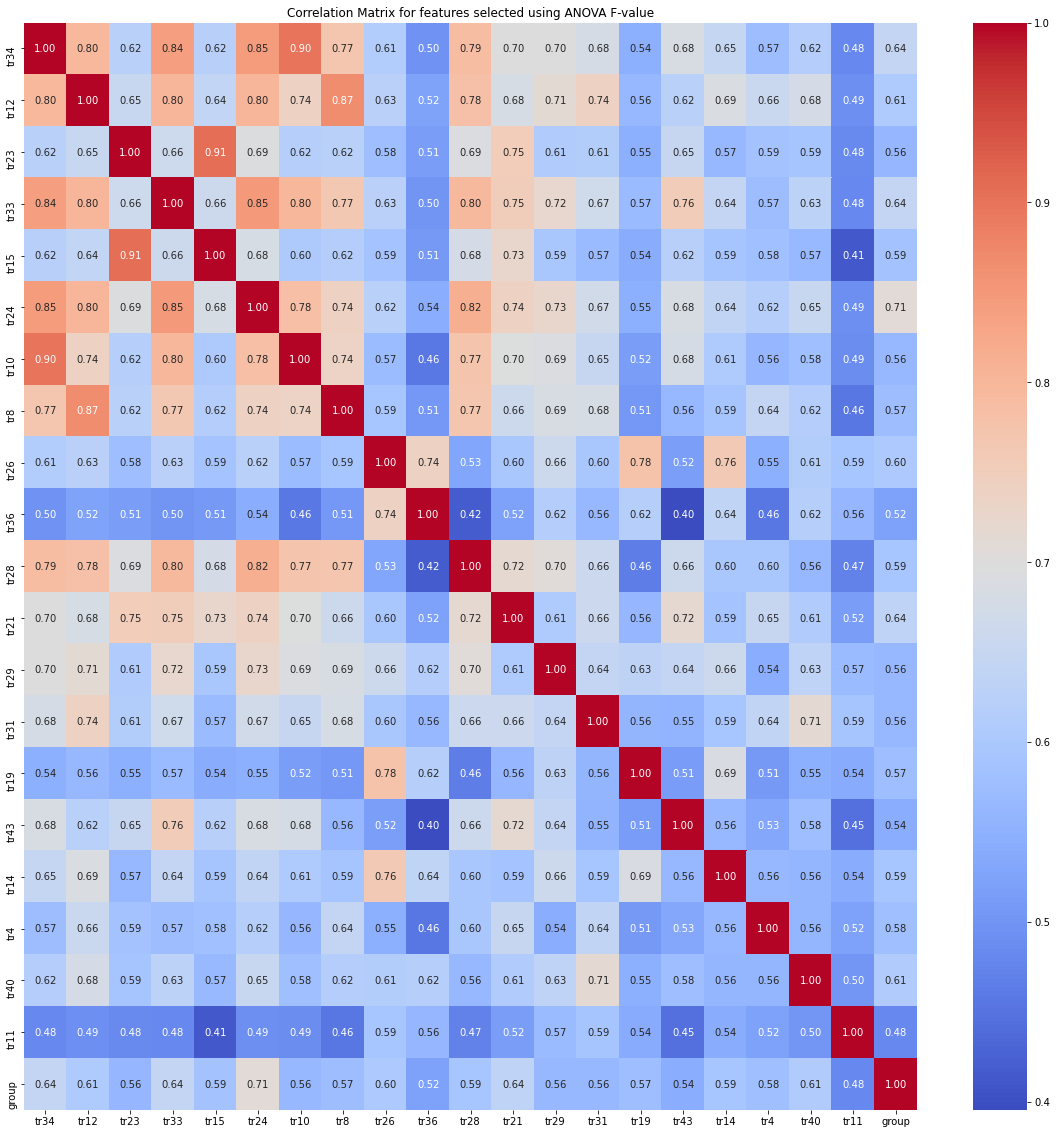

In [205]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection using SelectKBest with ANOVA F-value
k_best_features = SelectKBest(score_func=f_classif, k=num_features)
X_selected = k_best_features.fit_transform(X_train_scaled, y_train)

selected_feature_indices = k_best_features.get_support(indices=True)
fval_selected_features = X_train.columns[selected_feature_indices]

cols = fval_selected_features.tolist() + ['group']
print(cols)
corr = balanced_df[cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for features selected using ANOVA F-value')


In [206]:
overlapping_features = list(set(rfe_selected_features) & set(fval_selected_features))
overlapping_features

['tr4',
 'tr24',
 'tr19',
 'tr12',
 'tr28',
 'tr14',
 'tr23',
 'tr33',
 'tr15',
 'tr34',
 'tr40',
 'tr21',
 'tr8',
 'tr11']

In [207]:
X = X[rfe_selected_features].copy()

# VIF after RFE
vif_results = calculate_vif(X)
# iterate until all VIF values are less than 5
while vif_results['vif'].max() > 5:
    # find the column with the highest VIF
    max_vif_column = vif_results.loc[vif_results['vif'].idxmax(), 'var']
    print(f'dropping {max_vif_column}')
    # Remove the column with the highest VIF
    X = X.drop(columns=[max_vif_column])
    # Recalculate VIF
    vif_results = calculate_vif(X)

vif_results.sort_values(by='vif', ascending=True)

dropping tr23
dropping tr12
dropping tr24
dropping tr33


,var,vif
16,tr18,1.846123
15,tr11,1.915222
12,tr13,2.015407
14,tr20,2.114048
10,tr4,2.364880
13,tr40,2.383112
5,tr6,2.464373
2,tr15,2.661086
8,tr19,2.678986
11,tr35,2.695816


In [212]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Define evaluation metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation for RFE-selected features
rfe_scores = {}
for metric in scoring:
    scores = {}
    for clf_name, clf in classifiers.items():
        score = cross_val_score(clf, X_train[rfe_selected_features], y_train, cv=5, scoring=metric)
        scores[clf_name] = score.mean()
    rfe_scores[metric] = scores

# Perform cross-validation for F-anova-selected features
f_anova_scores = {}
for metric in scoring:
    scores = {}
    for clf_name, clf in classifiers.items():
        score = cross_val_score(clf, X_train[fval_selected_features], y_train, cv=5, scoring=metric)
        scores[clf_name] = score.mean()
    f_anova_scores[metric] = scores

# print mean scores
print("Mean Scores for RFE-selected features:")
for metric, scores in rfe_scores.items():
    print(metric)
    for clf_name, score in scores.items():
        print(f"{clf_name}: {score:.4f}")
    print()

print("\nMean Scores for F-anova-selected features:")
for metric, scores in f_anova_scores.items():
    print(metric)
    for clf_name, score in scores.items():
        print(f"{clf_name}: {score:.4f}")
    print()


Mean Scores for RFE-selected features:
accuracy
Random Forest: 0.9000
SVM: 0.8833
Logistic Regression: 0.9042

precision
Random Forest: 0.8987
SVM: 0.8554
Logistic Regression: 0.8939

recall
Random Forest: 0.9134
SVM: 0.9134
Logistic Regression: 0.9138

f1
Random Forest: 0.9029
SVM: 0.8831
Logistic Regression: 0.9012


Mean Scores for F-anova-selected features:
accuracy
Random Forest: 0.8833
SVM: 0.8708
Logistic Regression: 0.8750

precision
Random Forest: 0.9089
SVM: 0.8334
Logistic Regression: 0.8470

recall
Random Forest: 0.8960
SVM: 0.9221
Logistic Regression: 0.9054

f1
Random Forest: 0.8880
SVM: 0.8745
Logistic Regression: 0.8752



Looking at classification reports for Random Forest Classifier, Support Vector Machine and Logistic Regression models we can notice that models trained on RFE selected features seem to slightly outperform the ones trained on ANOVA F-value selected features, apart from a slight difference in recall. Therefore from now on, we will use the RFE (resursive feature elimination) selected features as the DSM-5 based questionnaire. 

In [213]:
screening_features = cols[:-1] # drop group
screening_features

# after that VIF
screening_features

['tr34', 'tr12', 'tr23', 'tr33', 'tr15', 'tr24', 'tr10', 'tr8', 'tr26', 'tr36', 'tr28', 'tr21', 'tr29', 'tr31', 'tr19', 'tr43', 'tr14', 'tr4', 'tr40', 'tr11', 'group']


['tr34',
 'tr12',
 'tr23',
 'tr33',
 'tr15',
 'tr24',
 'tr10',
 'tr8',
 'tr26',
 'tr36',
 'tr28',
 'tr21',
 'tr29',
 'tr31',
 'tr19',
 'tr43',
 'tr14',
 'tr4',
 'tr40',
 'tr11']

<h3>Questionnaire that will be used for the screening tool based on feature importance on a gender balanced dataset</h3>

In [210]:
# all pTRAQ questions
# load the pTRAQ questions description CSV dataset file into a DataFrame
ptraq_questions = pd.read_csv('pTRAQ_questions.csv', sep=';')
# drop last row
ptraq_questions.drop(ptraq_questions.index[-1], inplace=True) 
# add a column corresponding to the questionnaire dataset 
ptraq_questions = ptraq_questions.assign(question_code=[f'tr{i}' for i in range(1,43+1)])
dsm5_criteria = pd.read_csv('DSM5_ADHD_criteria.csv', sep=';')
# add columns with corresponding DSM-5 criteria and symptom category to pTRAQ questions
ptraq_questions = ptraq_questions.assign(dsm5_criteria=[c for c in dsm5_criteria['criteria_text']])
ptraq_questions = ptraq_questions.assign(symptom_category=[c for c in dsm5_criteria['category']])

screening_questions = ptraq_questions.drop(columns=['ID Critère', 'ID Projet', 'French Item (Validated)'])

screening_questions = screening_questions[screening_questions['question_code'].isin(screening_features)]
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
3,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
7,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
9,D,"I have difficulty completing my tasks (work, h...",tr10,Often does not follow through on instructions ...,inattention
10,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
11,E,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention
13,E,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention
14,F,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention
18,G,I often lose things I need for my work,tr19,Often loses things necessary for tasks or acti...,inattention
20,H,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention
22,H (C),I am easily distracted by what is going on aro...,tr23,Is often easily distracted by extraneous stimu...,inattention


In [211]:
# save the questionnaire into a csv format
file_name = 'screening_questions.csv'
screening_questions.to_csv(file_name, index=False, sep=';')